In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Koushik2003',
    database='e-commerce'
)
cursor = conn.cursor() #activate the cursor in database

# List all unique cities where customers are located. 

In [8]:
query = """select distinct customer_city from customers"""

cursor.execute(query)

data = cursor.fetchall()

#data
df=pd.DataFrame(data)
df.head(6)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul


# Count the number of orders placed in 2017.

In [5]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cursor.execute(query)

data = cursor.fetchall()

"Total orders placed in 2017",data[0][0]


('Total orders placed in 2017', 90202)

# Find the total sales per category.

In [6]:
 query = """select upper(products.product_category) as category,round(sum(payments.payment_value),2) as sales 
FROM `e-commerce`.products 
join `e-commerce`.order_items
on products.product_id=order_items.product_id
join `e-commerce`.payments
on payments.order_id=order_items.order_id
group by category """

cursor.execute(query)

data = cursor.fetchall()

df=pd.DataFrame(data,columns=["category","sales"]) # here we avoid visulisation because of more bar in graph.

print(df)

                       category       sales
0                     PERFUMERY  2026954.64
1          FURNITURE DECORATION  5720705.57
2                     TELEPHONY  1947528.20
3                BED TABLE BATH  6850214.68
4                    AUTOMOTIVE  3409177.32
..                          ...         ...
69               CDS MUSIC DVDS     4797.72
70                   LA CUISINE    11654.12
71  FASHION CHILDREN'S CLOTHING     3142.68
72                     PC GAMER     8697.72
73       INSURANCE AND SERVICES     1298.04

[74 rows x 2 columns]


# Calculate the percentage of orders that were paid in installments.

In [7]:
query = """select (sum(case when payment_installments>=1 then 1 else 0 end))*100/count(*) from `e-commerce`.payments"""

cursor.execute(query)

data = cursor.fetchall()

"The percentage of orders that were paid in installments is",data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.  


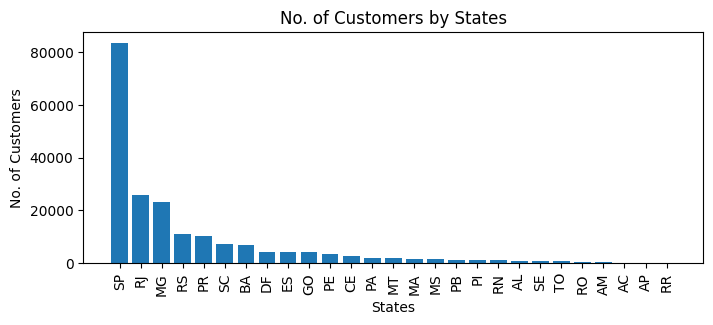

In [6]:
query = """select customer_state,count(customer_id) from customers group by customer_state"""

cursor.execute(query)

data = cursor.fetchall()
df=pd.DataFrame(data,columns=["State","No. of Customers"])
df=df.sort_values(by="No. of Customers",ascending=False)
#print(df)

plt.figure(figsize=(8,3))
plt.bar(df["State"],df["No. of Customers"])
plt.xlabel("States")
plt.ylabel("No. of Customers")
plt.title("No. of Customers by States")
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

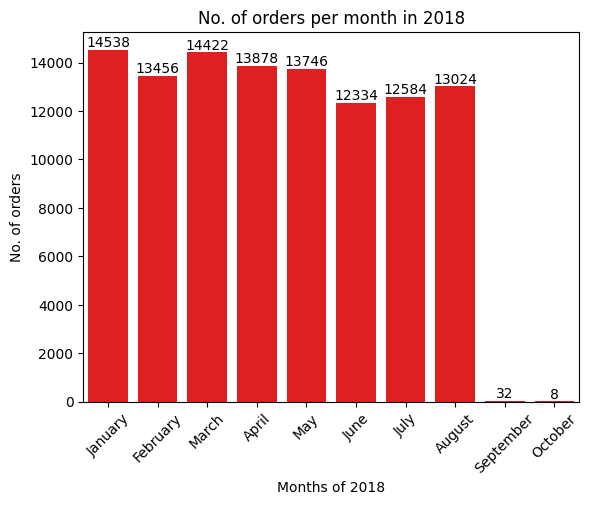

In [7]:
query = """select monthname(order_purchase_timestamp),count(order_id) from orders 
where year(order_purchase_timestamp)=2018 
group by monthname(order_purchase_timestamp)
order by count(order_id)"""

cursor.execute(query)

data = cursor.fetchall()
df=pd.DataFrame(data,columns=["Months of 2018","No. of orders"])
#df
o=["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x=df["Months of 2018"],y=df["No. of orders"],data=df,order=o,color="red")
plt.xticks(rotation=45)
plt.title("No. of orders per month in 2018")
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.


In [8]:
# calculation of per order avg.when we take order_items then we know 1 order_id buy items how much time.
# We can use CTE in this case.

query = """with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from `e-commerce`.orders join `e-commerce`.order_items on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) as average_order 
from `e-commerce`.customers join count_per_order on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_order desc"""

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["City","Avg products/order"])
df.head(10)


,City,Avg products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,picarra,16.00
7,morro de sao paulo,16.00
8,teixeira soares,16.00
9,curralinho,16.00


# Calculate the percentage of total revenue contributed by each product category.

In [9]:
 query = """select upper(products.product_category) as category,round((sum(payments.payment_value)/(select sum(payment_value) from `e-commerce`.payments))*100,2) as percentage_sales 
FROM `e-commerce`.products 
join `e-commerce`.order_items
on products.product_id=order_items.product_id
join `e-commerce`.payments
on payments.order_id=order_items.order_id
group by category """

cursor.execute(query)

data = cursor.fetchall()

df=pd.DataFrame(data,columns=["category","percentage_distribution"]) # here we avoid visulisation because of more bar in graph.

print(df)

                       category  percentage_distribution
0                     PERFUMERY                    12.66
1          FURNITURE DECORATION                    35.73
2                     TELEPHONY                    12.17
3                BED TABLE BATH                    42.79
4                    AUTOMOTIVE                    21.30
..                          ...                      ...
69               CDS MUSIC DVDS                     0.03
70                   LA CUISINE                     0.07
71  FASHION CHILDREN'S CLOTHING                     0.02
72                     PC GAMER                     0.05
73       INSURANCE AND SERVICES                     0.01

[74 rows x 2 columns]


# Identify the correlation between product price and the number of times a product has been purchased.

In [18]:
 query = """select products.product_category,count(order_items.product_id),round(avg(order_items.price),2) 
from `e-commerce`.products join `e-commerce`.order_items
on products.product_id=order_items.product_id
group by  products.product_category """

cursor.execute(query)

data = cursor.fetchall()

df=pd.DataFrame(data,columns=["category","order_count","price"]) 

arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2]) #the value is neutral it's not closer to (-0.5) thus there is n o any relation btw. in purchase & price

print("The correlation bet. price & number of times product purchased is",a[0][1]) #because it is a 2d array

The correlation bet. price & number of times product purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.


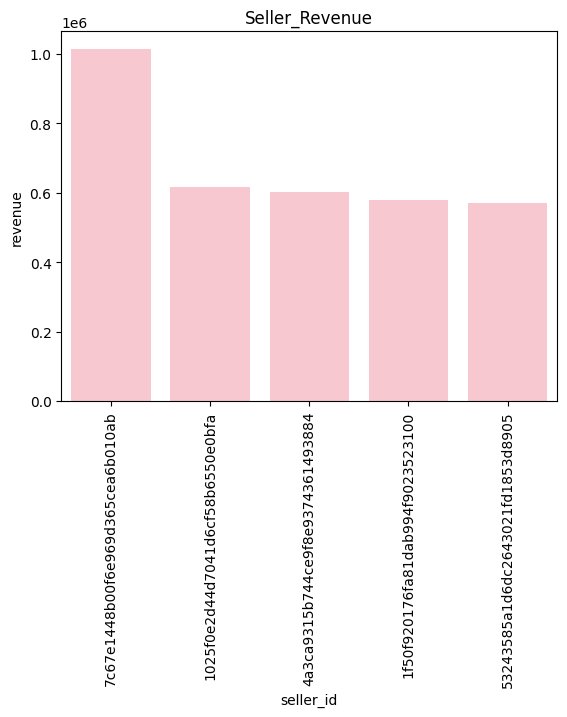

In [36]:
query = """ select * ,dense_rank() over(order by revenue desc) as ranks from (select order_items.seller_id,sum(payments.payment_value) as revenue
from `e-commerce`.order_items join `e-commerce`.payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"]) 
df=df.head()

sns.barplot(x=df["seller_id"],y=df["revenue"],data=df,color="pink")
plt.xticks(rotation=90)
plt.title("Seller_Revenue")
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [39]:
query = """ select customer_id,order_purchase_timestamp,payments,
avg(payments) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as moving_row
from (select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payments
from `e-commerce`.orders join `e-commerce`.payments
on orders.order_id=payments.order_id) as a """

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","payments","moving_avg_payments_values"])
df               

,customer_id,order_purchase_timestamp,payments,moving_avg_payments_values
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

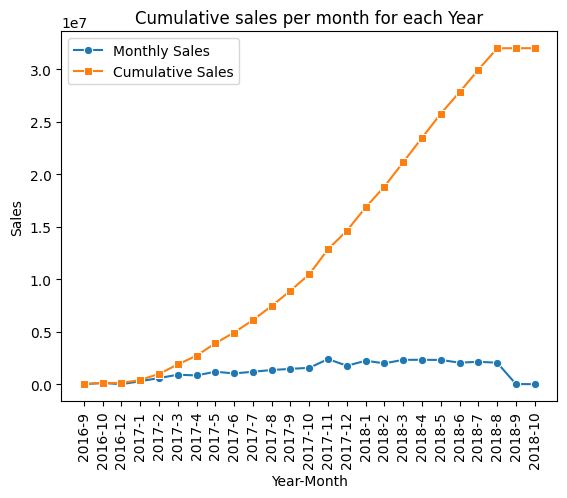

<Figure size 1200x1600 with 0 Axes>

In [17]:
query="""select years,months,payments,
sum(payments) over(order by years,months) from
(select year(orders.order_purchase_timestamp) as years,month(orders.order_purchase_timestamp) as months,round(sum(payments.payment_value),2) as payments
from `e-commerce`.orders join `e-commerce`.payments
on orders.order_id=payments.order_id
group by years,months order by years, months) as a"""

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["Year","Month","Sales","Cumulative Sales"])
df["Year-Month"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)
#df   

sns.lineplot(data=df, x="Year-Month", y="Sales", marker='o', label="Monthly Sales")
sns.lineplot(data=df, x="Year-Month", y="Cumulative Sales", marker='s', label="Cumulative Sales")
plt.xticks(rotation=90)
plt.title("Cumulative sales per month for each Year")
plt.figure(figsize=(12,8))
plt.show()

# Calculate the year-over-year growth rate of total sales.

In [10]:
#we can use CTE or Sub-Query both
query="""with a as(select year(orders.order_purchase_timestamp) as years,round(sum(payments.payment_value),2) as payments
from `e-commerce`.orders join `e-commerce`.payments
on orders.order_id=payments.order_id
group by years order by years)

select years,((payments-lag(payments,1) over(order by years))/lag(payments,1) over(order by years))*100 from a""" #lag() is use for previous data

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["Year","YoY_Growth_rate"])
df

,Year,YoY_Growth_rate
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [29]:
#how we find retention rate
#min is use to find the first ever purchase date of each customer.
#date_add use to find customers who made another purchase more than 6 months after their first order. 
query="""with a as(select customers.customer_id,min(orders.order_purchase_timestamp) as first_order 
from `e-commerce`.customers join `e-commerce`.orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),
 
b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order
from a join `e-commerce`.orders
on a.customer_id=orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) from 
a left join b
on a.customer_id=b.customer_id"""

cursor.execute(query)

data = cursor.fetchall()

data #Here none is come means, no one available who purchase within 6 months.

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

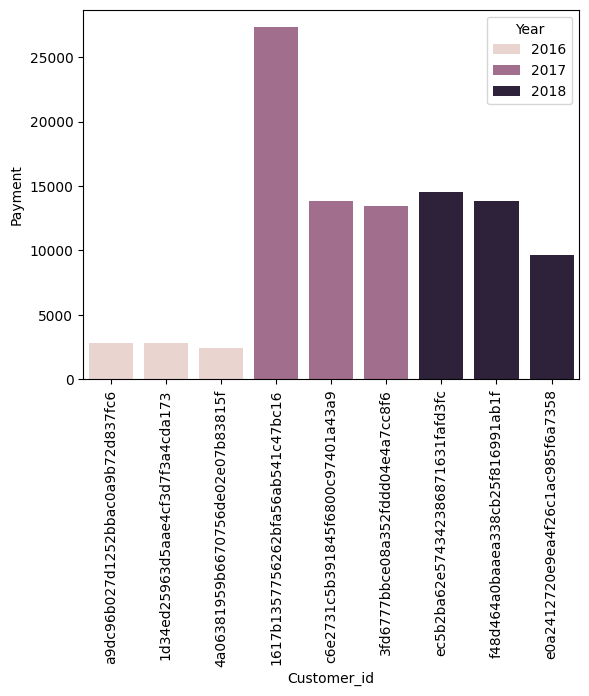

In [31]:
query="""select years,customer_id,payment from

(select year(orders.order_purchase_timestamp) years,orders.customer_id,sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from `e-commerce`.orders join `e-commerce`.payments on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a

where d_rank<=3"""

cursor.execute(query)

data = cursor.fetchall()

df=pd.DataFrame(data,columns=["Year","Customer_id","Payment"])

sns.barplot(x="Customer_id",y="Payment",data=df,hue="Year")
plt.xticks(rotation=90)
plt.show()